In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('paris_temperature.csv')

In [4]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2,"Paris,France",2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,...,4.8,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
3,"Paris,France",2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,...,5.1,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
4,"Paris,France",2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,...,3.5,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Question 1

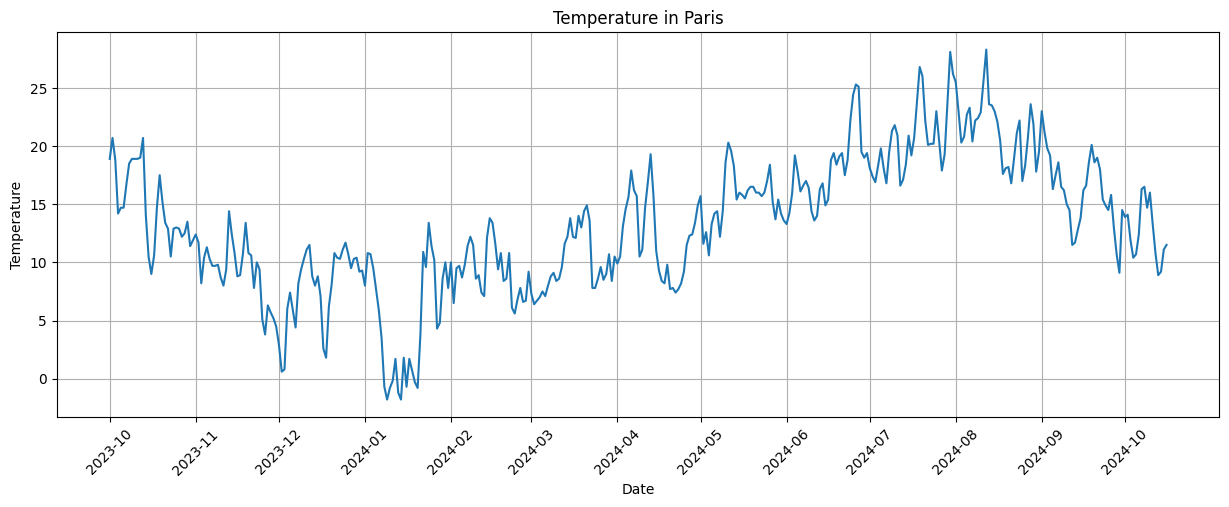

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

# Question 2

| **Feature**              | **Meaning**                                                                                                   | **Values**                                                |
|--------------------------|---------------------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| `name`                   | The location of the recorded weather                                                                          | All are "Paris,France"                                  |
| `datetime`               | The date (without time) of the recorded weather in ISO 8601 format (YYYY-MM-DD)                            | Ranging from October 1st 2023 to October 16th 2024      |
| `tempmax`                | The maximum recorded temperature                                                                               | From -1.3 to 36.2, recorded in degree Celsius           |
| `tempmin`                | The minimum recorded temperature                                                                               | From -4.1 to 21.2, recorded in degree Celsius           |
| `temp`                   | The average temperature of the day                                                                             | From -1.8 to 28.3, recorded in degree Celsius           |
| `feelslikemax`          | The maximum "feels like" temperature of the recorded day                                                      | From -5.5 to 39.0, recorded in degree Celsius           |
| `feelslikemin`          | The minimum "feels like" temperature of the recorded day                                                      | From -7.3 to 21.2, recorded in degree Celsius           |
| `feelslike`              | The average "feels like" temperature of the recorded day                                                     | From -6.3 to 29.6, recorded in degree Celsius           |
| `dew`                    | The atmospheric temperature below which water droplets begin to condense                                      | From -6.1 to 20.3, recorded in degree Celsius           |
| `humidity`               | A quantity representing the amount of water vapor in the atmosphere                                            | From 51.6% to 95.0%                                     |
| `precip`                 | The amount of water falling from the sky (rain, drizzle, snow, sleet, hail, etc.)                           | From 0.0 to 25.008, recorded in millimeters             |
| `precipprob`             | The probability of precipitation occurring (possibly recorded after precipitation occurred)                    | 0 if no precipitation, 100 otherwise                     |
| `precipcover`            | The percentage of the area that received precipitation                                                         | 0 if no precipitation; 3.2% to 100% for others           |
| `preciptype`             | The type of precipitation                                                                                      | Empty for no precipitation; possible values: "rain", "rain,snow", or "rain,freezingrain,snow" |
| `snow`                   | The amount of snow recorded                                                                                   | 0 for days without snow; 0.1 to 5.4 recorded in mm      |
| `snowdepth`              | The depth of snow on the ground                                                                                | 0 for most days without snow; 0.1 to 3.9 recorded in mm  |
| `windgust`               | The maximum wind gust speed recorded                                                                            | From 14.4 to 92.2, unknown unit                          |
| `windspeed`              | The average sustained wind speed recorded                                                                      | From 6.8 to 44.3, unknown unit                           |
| `winddir`                | The direction of the wind                                                                                     | In compass degrees (0-360)                               |
| `sealevelpressure`       | The atmospheric pressure at mean sea level                                                                     | From 979.7 to 1042.8, unknown unit                       |
| `cloudcover`             | The percentage of cloud cover                                                                                  | From 13.0% to 100.0%                                    |
| `visibility`             | The measure of the distance at which an object or light can be clearly discerned                                | From 5.1 to 39.1, unknown unit                           |
| `solarradiation`         | The recorded value of solar radiation                                                                           | From 0.0 to 169.8                                       |
| `solarenergy`            | The total energy released from the sun that is absorbed in the recorded area                                   | From 0.0 to 14.7                                        |
| `uvindex`                | The UV index indicating the strength of ultraviolet radiation from the sun                                     | Integer values from 0 to 8                               |
| `severerisk`             | A risk rating indicating the severity of weather conditions                                                    | All entries have the value of 10                         |
| `sunrise`                | The time of sunrise                                                                                           | Recorded in ISO 8601 format (YYYY-MM-DDThh:mm:ss)       |
| `sunset`                 | The time of sunset                                                                                            | Recorded in ISO 8601 format (YYYY-MM-DDThh:mm:ss)       |
| `moonphase`              | The shape of the visible moon (moon phase)                                                                    | Ratio of visible moon area; 0 for new moon, 1 for full moon |
| `conditions`             | A summary of the weather conditions                                                                           | Contains type(s) of precipitation and cloud amount       |
| `description`            | A detailed description of the daily weather                                                                    | Text describing the weather of the recorded day          |
| `icon`                   | An icon representing the dominant weather conditions                                                          | String that indicates the weather type                   |
| `stations`               | A list of weather stations that provided the data                                                             | CSV list of strings identifying the stations              |

# Question 3

In [7]:
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [8]:
df_numerical = df[numerical_features]
df_numerical.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70


# Question 4

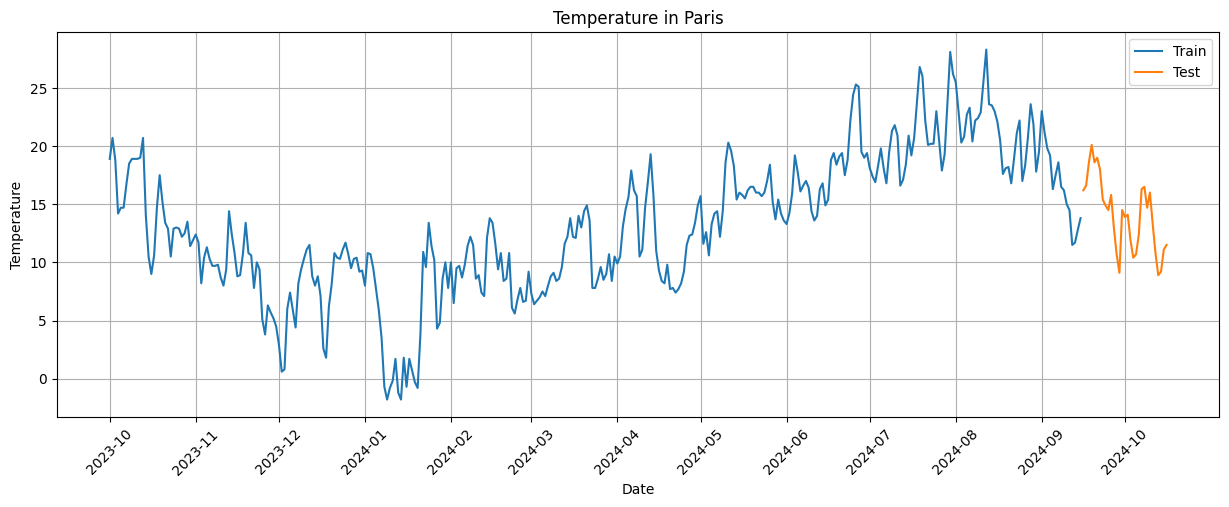

X_train shape: (351, 23), y_train shape: (351,)
X_test shape: (31, 23), y_test shape: (31,)


In [9]:
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

X = df_numerical[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 
                  'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 
                  'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 
                  'uvindex', 'severerisk', 'moonphase']].values

y = df_numerical['temp'].values

train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Question 6
### Feature engineering the categorical data

In [10]:
df[categorical_features].head()

,name,preciptype,sunrise,sunset,conditions,description,icon,stations
datetime,,,,,,,,
2023-10-01,"Paris,France",rain,2023-10-01T07:49:34,2023-10-01T19:30:27,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
2023-10-02,"Paris,France",NaN,2023-10-02T07:51:01,2023-10-02T19:28:21,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2023-10-03,"Paris,France",rain,2023-10-03T07:52:29,2023-10-03T19:26:16,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
2023-10-04,"Paris,France",rain,2023-10-04T07:53:57,2023-10-04T19:24:10,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
2023-10-05,"Paris,France",rain,2023-10-05T07:55:25,2023-10-05T19:22:06,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [11]:
print(f"Number of unique values:\n{df[categorical_features].nunique()}")

Number of unique values:
name             1
preciptype       3
sunrise        382
sunset         382
conditions       8
description     31
icon             5
stations        27
dtype: int64


In [12]:
print(f"{df[categorical_features]['preciptype'].nunique()} cols of Precipation: {list(df[categorical_features]['preciptype'].unique())}")
print(f"{df[categorical_features]['conditions'].nunique()} cols of Conditions: {list(df[categorical_features]['conditions'].unique())}")
print(f"{df[categorical_features]['description'].nunique()} cols of Description: {list(df[categorical_features]['description'].unique())}")
print(f"{df[categorical_features]['icon'].nunique()} cols of Icon: {list(df[categorical_features]['icon'].unique())}")
print(f"{df[categorical_features]['stations'].nunique()} cols of Stations: {list(df[categorical_features]['stations'].unique())}")

3 cols of Precipation: ['rain', nan, 'rain,snow', 'rain,freezingrain,snow']
8 cols of Conditions: ['Rain, Partially cloudy', 'Partially cloudy', 'Clear', 'Rain, Overcast', 'Overcast', 'Snow, Rain, Overcast', 'Snow, Rain, Partially cloudy', 'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy']
31 cols of Description: ['Partly cloudy throughout the day with morning rain.', 'Partly cloudy throughout the day.', 'Partly cloudy throughout the day with rain in the morning and afternoon.', 'Clear conditions throughout the day.', 'Partly cloudy throughout the day with late afternoon rain.', 'Cloudy skies throughout the day with morning rain.', 'Cloudy skies throughout the day with rain.', 'Partly cloudy throughout the day with rain.', 'Cloudy skies throughout the day with a chance of rain throughout the day.', 'Partly cloudy throughout the day with a chance of rain throughout the day.', 'Partly cloudy throughout the day with rain clearing later.', 'Partly cloudy throughout the day wit

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_categorical_processed = pd.DataFrame(columns=['Preciptype', 'Sunrise_minutes', 'Sunset_minutes', 'Daylight_duration', 'Conditions', 'Description', 'Icon'])
df_categorical_processed['Preciptype'] = df[categorical_features]['preciptype'].fillna('none')
preciptype_dummies = df_categorical_processed['Preciptype'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, preciptype_dummies], axis=1)
df_categorical_processed['Sunrise_minutes'] = df[categorical_features]['sunrise'].str.split('T').str[1].apply(lambda x: int(x[:2])*60 + int(x[3:5]))
df_categorical_processed['Sunset_minutes'] = df[categorical_features]['sunset'].str.split('T').str[1].apply(lambda x: int(x[:2])*60 + int(x[3:5]))
df_categorical_processed['Daylight_duration'] = df_categorical_processed['Sunset_minutes'] - df_categorical_processed['Sunrise_minutes']
df_categorical_processed['Conditions'] = df[categorical_features]['conditions']
conditions_dummies = df_categorical_processed['Conditions'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, conditions_dummies], axis=1)
df_categorical_processed['Description'] = TfidfVectorizer(max_features=100).fit_transform(df[categorical_features]['description']).toarray()
df_categorical_processed['Icon'] = df[categorical_features]['icon']
icon_dummies = df_categorical_processed['Icon'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, icon_dummies], axis=1)
df_categorical_processed.drop(columns=['Preciptype', 'Conditions', 'Icon'], inplace=True)
df_categorical_processed

,Sunrise_minutes,Sunset_minutes,Daylight_duration,Description,freezingrain,none,rain,snow,Freezing Drizzle/Freezing Rain,Overcast,...,Clear,Overcast,Partially cloudy,Rain,Snow,clear-day,cloudy,partly-cloudy-day,rain,snow
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,469,1170,701,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-02,471,1168,697,0.000000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2023-10-03,472,1166,694,0.359391,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-04,473,1164,691,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-05,475,1162,687,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-12,487,1146,659,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2024-10-13,488,1144,656,0.000000,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2024-10-14,490,1142,652,0.000000,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [14]:
df_total = pd.concat([df_numerical, df_categorical_processed], axis=1)
df_total.to_csv('df_total.csv')

In [15]:
X = df_total.drop(columns=['temp']).values
y = df_numerical['temp'].values
train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (351, 45), y_train shape: (351,)
X_test shape: (31, 45), y_test shape: (31,)


# Question 7
### (a) Applying LSTM model

In [16]:
def reshape_lstm_input(X, y, n_past):
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    X_reshaped = []
    y_reshaped = []

    for i in range(n_past, len(X)):
        X_reshaped.append(X[i - n_past:i])
        y_reshaped.append(y[i])

    return np.array(X_reshaped), np.array(y_reshaped), scaler_X, scaler_y

n_past = 1
n_features = X_train.shape[1]

X_train_reshaped, y_train_reshaped, scaler_X, scaler_y = reshape_lstm_input(X_train, y_train, n_past)
X_test_reshaped, y_test_reshaped, _, _ = reshape_lstm_input(X_test, y_test, n_past)

if X_train_reshaped is not None and X_test_reshaped is not None:
    print("X_train_reshaped shape:", X_train_reshaped.shape)
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    print("X_test_reshaped shape:", X_test_reshaped.shape)
    print("y_test_reshaped shape:", y_test_reshaped.shape)

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_reshaped, dtype=torch.float32)

X_train_reshaped shape: (350, 1, 45)
y_train_reshaped shape: (350, 1)
X_test_reshaped shape: (30, 1, 45)
y_test_reshaped shape: (30, 1)


In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

In [ ]:
input_size = X_train_tensor.shape[2]
hidden_size = 400
num_layers = 4
output_size = 1
dropout_prob = 0.0
learning_rate = 0.001
num_epochs = 200
early_stopping_patience = 15
checkpoint_path = "best_lstm_model_5.pth"

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
)

best_val_loss = float('inf')
no_improvement_epochs = 0
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
 
    for i in range(len(X_train_tensor)):
        optimizer.zero_grad()
        outputs = model(X_train_tensor[i:i+1]) 
        loss = criterion(outputs, y_train_tensor[i:i+1])
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            outputs = model(X_test_tensor[i:i+1])
            loss = criterion(outputs, y_test_tensor[i:i+1])
            epoch_val_loss += loss.item()

    train_loss = epoch_train_loss / len(X_train_tensor)
    val_loss = epoch_val_loss / len(X_test_tensor)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved to {checkpoint_path} with Val Loss: {best_val_loss:.4f}")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break ## add rmse for model checkpoint

C:\Users\ADM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.0252, Val Loss: 0.0906
Model saved to best_lstm_model_5.pth with Val Loss: 0.0906
Epoch [2/200], Train Loss: 0.0163, Val Loss: 0.0875
Model saved to best_lstm_model_5.pth with Val Loss: 0.0875
Epoch [3/200], Train Loss: 0.0157, Val Loss: 0.0929


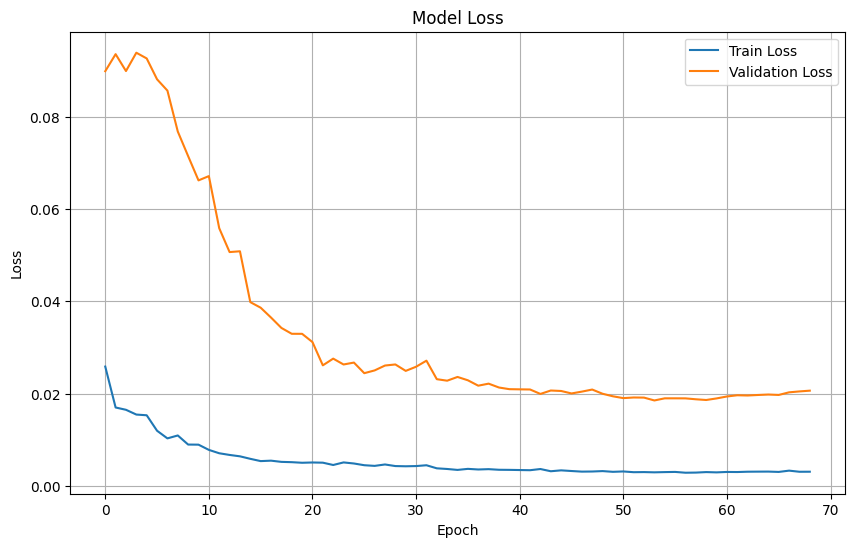

MAE: 3.2872
MSE: 16.7850
RMSE: 4.0969
R2 Score: 0.7604


In [ ]:
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid()
plt.show()

with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    y_test_actual = y_test_tensor.numpy()
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test_actual)
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

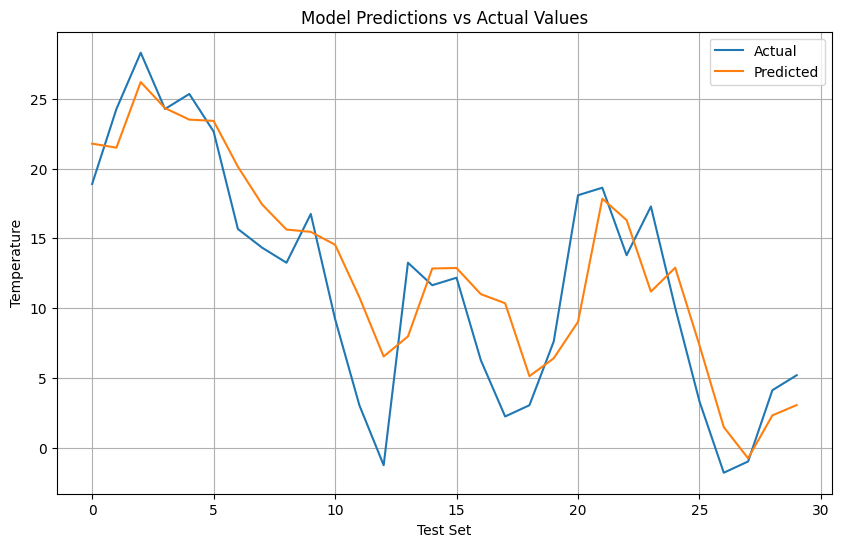

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Test Set")
plt.ylabel("Temperature")
plt.grid()
plt.show()

In [ ]:
df_categorical = df[categorical_features]
df_categorical = df_categorical.drop(['name'], axis=1)
df_categorical.head()
df_categorical.to_csv("paris_categorical.csv", index=True)

# LSTM Formula

### 1. Forget Gate
$$
f_t = \sigma(W_f h_{t-1} + U_f x_t + b_f)
$$

- **$f_t$**: Forget gate activation vector (controls what information to discard).
- **$\sigma$**: Sigmoid activation function (outputs values between 0 and 1).
- **$W_f$**: Weight matrix for the previous hidden state $h_{t-1}$.
- **$h_{t-1}$**: Previous hidden state vector (output from the last time step).
- **$U_f$**: Weight matrix for the current input $x_t$.
- **$x_t$**: Current input vector at time $t$.
- **$b_f$**: Bias vector for the forget gate.

### 2. Input Gate
$$
i_t = \sigma(W_i h_{t-1} + U_i x_t + b_i)
$$

- **$i_t$**: Input gate activation vector (controls what new information to add).
- **$W_i$**: Weight matrix for the previous hidden state $h_{t-1}$.
- **$U_i$**: Weight matrix for the current input $x_t$.
- **$b_i$**: Bias vector for the input gate.

### 3. Cell State Update
$$
\tilde{C}_t = \tanh(W_C h_{t-1} + U_C x_t + b_C)
$$

- **$\tilde{C}_t$**: Candidate cell state (the new information to be added to the cell state).
- **$\tanh$**: Hyperbolic tangent activation function (outputs values between -1 and 1).
- **$W_C$**: Weight matrix for the previous hidden state $h_{t-1}$.
- **$U_C$**: Weight matrix for the current input $x_t$.
- **$b_C$**: Bias vector for the cell state update.

### 4. Cell State
$$
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
$$

- **$C_t$**: Current cell state (memory of the LSTM).
- **$C_{t-1}$**: Previous cell state (the memory from the last time step).
- **$\odot$**: Hadamard product (element-wise multiplication).
- This equation combines the retained information from the previous state (controlled by $f_t$) and the new information (controlled by $i_t$).

### 5. Output Gate
$$
o_t = \sigma(W_o h_{t-1} + U_o x_t + b_o)
$$

- **$o_t$**: Output gate activation vector (controls what part of the cell state to output).
- **$W_o$**: Weight matrix for the previous hidden state $h_{t-1}$.
- **$U_o$**: Weight matrix for the current input $x_t$.
- **$b_o$**: Bias vector for the output gate.

### 6. Hidden State
$$
h_t = o_t \odot \tanh(C_t)
$$

- **$h_t$**: Current hidden state (output of the LSTM cell).
- **$\tanh(C_t)$**: Applies the hyperbolic tangent function to the current cell state to normalize the values.
- **$o_t$**: Output gate activation vector determines how much of the cell state to output as the hidden state  